In this notebook we try to explore possible network architectures for our Image-to-Image translation problem. In this regard, we will begin with a simplified problem where we only use one filter (*gotham* filter).

## Architecture

The architecture of the network is inspired by the one proposed by [Izuka and Simo-Serra](http://hi.cs.waseda.ac.jp/%7Eiizuka/projects/colorization/data/colorization_sig2016.pdf) and illustrated below

![](https://cloud.githubusercontent.com/assets/22426131/20623098/5031fff4-b31b-11e6-8594-a54e83fce131.PNG)

Our network will have two branches:

1. **Feature Extractor**: This branch will be in charge of extracting relevant features of the input picture. To this end, we use the Inception-Resnet-V2 pre-trained model. In particular we use the last layer before applying Softmax. 
2. **Encoder-Decoder**: This branch works similar to an autoencoder. Furthermore, it contains a *Merge Layer* which merges the extracted features from branch 1.


In this notebook, we initially only consider just the 2. Our main goal here, is to see if the network is able to overfit a small dataset.

# Load Images

The loading of the images is temporal, in the future we will be using TFRecord files! However, for this little test, this method is enough. For this test, I have created two folders inside `~/imagenet/`. Namely, `~/imagenet/resized_` and `~/imagenet/filtered_` which contain the 8 resized original pictures and resized filtered pictures. **Note**: Only using Gotham filter! This reduction on the set is made to verify and check if we can overfit these samples using our network.

In [1]:
# Import pillow image libraries and matplotlib to illustrate images
%matplotlib inline
from PIL import Image, ImageChops, ImageOps
from matplotlib import pyplot as plt
# Import libraries to list and create directories
import os 
import glob
import numpy as np

In [2]:
# Substitute with your path
directory_output = "/Users/lucasrodesguirao/imagenet/resized_"
directory_input = "/Users/lucasrodesguirao/imagenet/filtered_"

In [3]:
# Load images
images_in = []
images_out = []

for filename_image_out in os.listdir(directory_output):
    if filename_image_out.endswith("jpg") or filename_image_out.endswith("jpeg") \
    or filename_image_out.endswith("JPG") or filename_image_out.endswith("JPEG"):
        path_to_images_in = glob.glob(directory_input+"/"+filename_image_out.split(".")[0]+"*")
        path_to_image_out = os.path.join(directory_output, filename_image_out)
        image_out = Image.open(path_to_image_out)      
        image_out = np.array(image_out)
        for path_to_image_in in path_to_images_in: 
            image_in = Image.open(path_to_image_in) 
            image_in = np.array(image_in)
            images_in.append(image_in)
            images_out.append(image_out)

images_in = np.array(images_in)
images_out = np.array(images_out)

In [4]:
# Scale and center
images_out_processed = (images_out-127.5)/127.5
images_in_processed = (images_in-127.5)/127.5

# Define Computational Graph
Now time to define the network architecture. To this end, we will use Keras API, since it saves us a lot of time! Needless to say that we will be using TensorFlow as Backend.

In [5]:
import tensorflow as tf
sess = tf.Session()

import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

K.set_session(sess)

Using TensorFlow backend.


In [6]:
# this placeholder will contain our input images
img_in = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))
img_out = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

We define the encoder and decoder networks. For the encoder, we only use convolutional and max pooling layers. Furthermore, we use ReLu as the activation function. 

In [14]:
# Encoder
def encoder(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

For the decoder, we use the same architecture but reversed. In addition, the last layer uses Tanh activation. Note that once processed, image pixels range [-1, 1] and thus makes it suitable to use Tanh in the last layer!

In [28]:
# Decoder
def decoder(encoded):
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    print(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    print(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    print(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='tanh')(x)
    return decoded

We define the model using the decoder and encoder methods.

In [29]:
# Construct model
encoder_op = encoder(img_in)
decoder_op = decoder(encoder_op)

Tensor("up_sampling2d_24/ResizeNearestNeighbor:0", shape=(?, 38, 38, 128), dtype=float32)
Tensor("up_sampling2d_25/ResizeNearestNeighbor:0", shape=(?, 76, 76, 128), dtype=float32)
Tensor("up_sampling2d_26/ResizeNearestNeighbor:0", shape=(?, 152, 152, 64), dtype=float32)


We define the cost as the L2 pixel distance between the estimated and original picture. Furthermore, we use AdamOptimizer.

In [32]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = img_out[:,:298,:298]
# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred)), name="mse")
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# Training

Time for training😀😀 We initialize our variables and run the session. We also set the number of epochs and the batch size. Note that we use all the samples in the set (8) as the batch.

In [33]:
# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [34]:
training_epochs = 100
batch_size = 8
total_batches = len(images_in)//batch_size

In [35]:
idx = np.arange(len(images_in))
# Run training loop
with sess.as_default():
    for epoch in range(training_epochs):
        np.random.shuffle(idx)
        images_in_processed = images_in_processed[idx]
        images_out_processed = images_out_processed[idx]
        print("\nepoch:", epoch)
        for i in range(total_batches):
            batch_in = images_in_processed[i*batch_size:(i+1)*batch_size]
            batch_out = images_out_processed[i*batch_size:(i+1)*batch_size]
            _, c = sess.run([optimizer, cost], feed_dict={img_in: batch_in, img_out: batch_out})
            print(str(i)+", Cost =  ", c)


epoch: 0
0, Cost =   0.504106

epoch: 1
0, Cost =   0.424794

epoch: 2
0, Cost =   0.425303

epoch: 3
0, Cost =   0.48798

epoch: 4
0, Cost =   0.323853

epoch: 5
0, Cost =   0.296372

epoch: 6
0, Cost =   0.323502

epoch: 7
0, Cost =   0.29819

epoch: 8
0, Cost =   0.282647

epoch: 9
0, Cost =   0.261322

epoch: 10
0, Cost =   0.241041

epoch: 11
0, Cost =   0.246063

epoch: 12
0, Cost =   0.223737

epoch: 13
0, Cost =   0.206128

epoch: 14
0, Cost =   0.215206

epoch: 15
0, Cost =   0.184665

epoch: 16
0, Cost =   0.173252

epoch: 17
0, Cost =   0.176485

epoch: 18
0, Cost =   0.179393

epoch: 19
0, Cost =   0.158074

epoch: 20
0, Cost =   0.152748

epoch: 21
0, Cost =   0.153391

epoch: 22
0, Cost =   0.143658

epoch: 23
0, Cost =   0.139825

epoch: 24
0, Cost =   0.130269

epoch: 25
0, Cost =   0.130736

epoch: 26
0, Cost =   0.125562

epoch: 27
0, Cost =   0.118311

epoch: 28
0, Cost =   0.115965

epoch: 29
0, Cost =   0.112371

epoch: 30
0, Cost =   0.112268

epoch: 31
0, Cost =

Once we have our model, we simply evaluate it using some samples. In this first approach, we use training samples here but in the future we should be using validation samples.

In [36]:
image_in = images_in_processed
image_out = images_out_processed
# Run training loop
with sess.as_default():
    pred, true = sess.run([y_pred, y_true], feed_dict={img_in: image_in, img_out: image_out})

Finally, we plot our results in order to see how good the reconstruction is.

/Users/lucasrodesguirao/git/hashtag-nofilter/.env/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


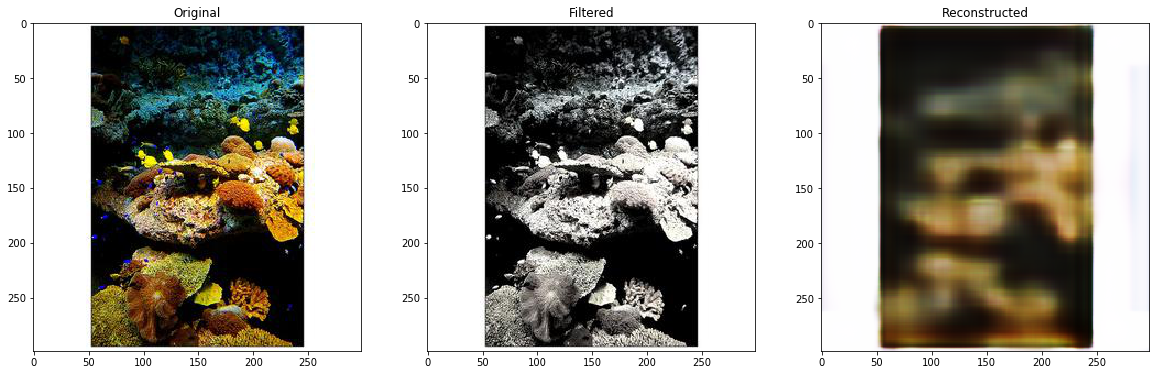

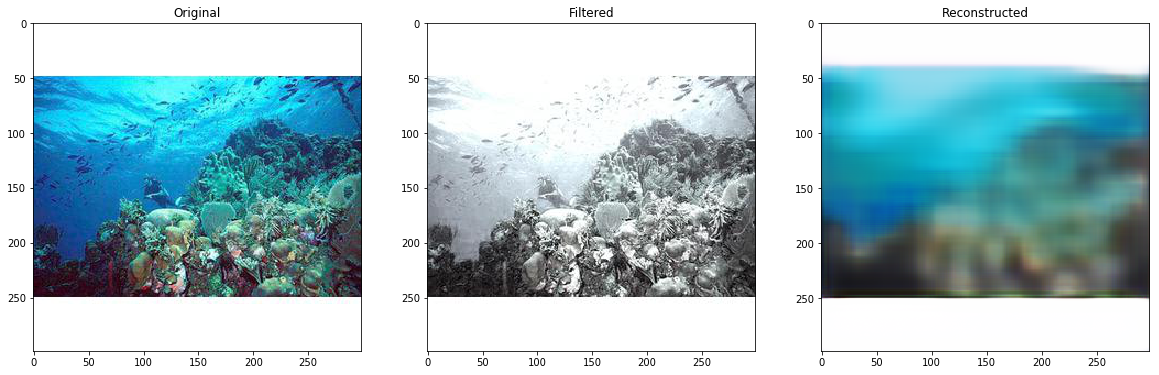

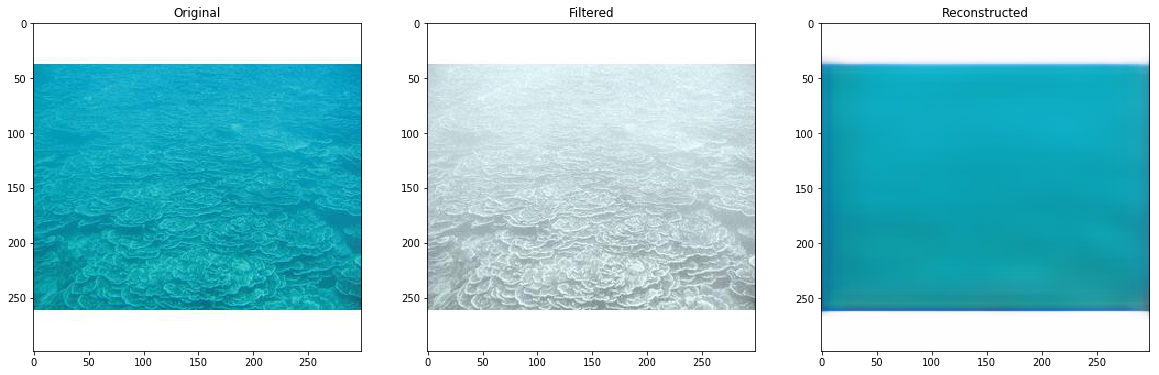

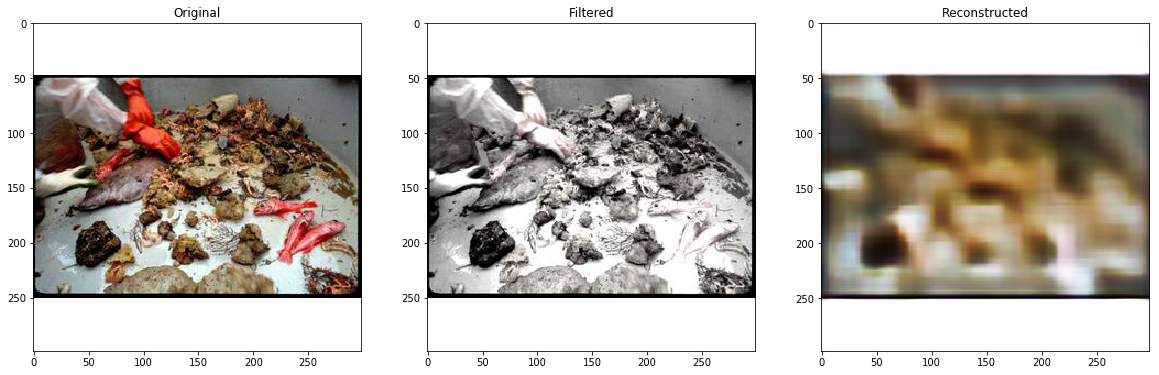

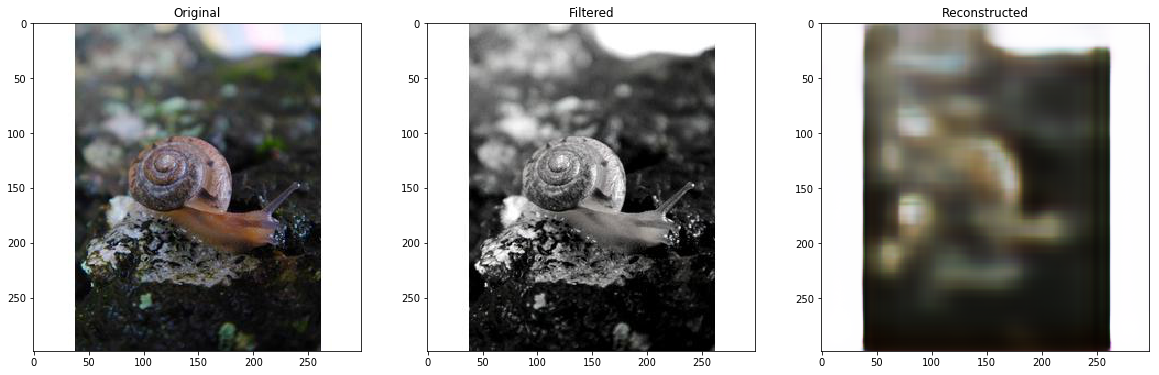

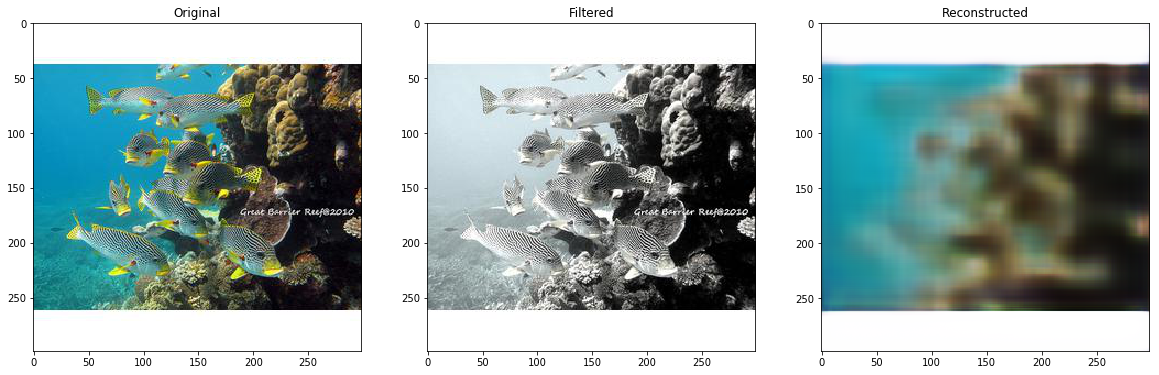

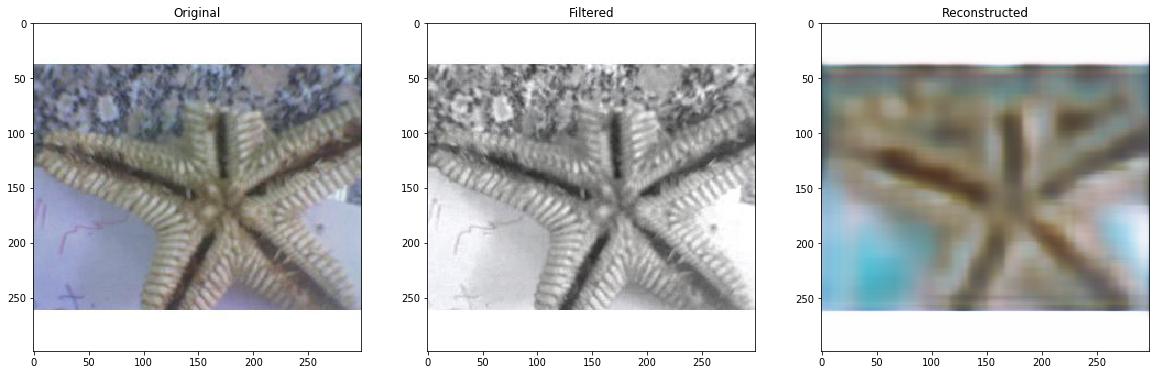

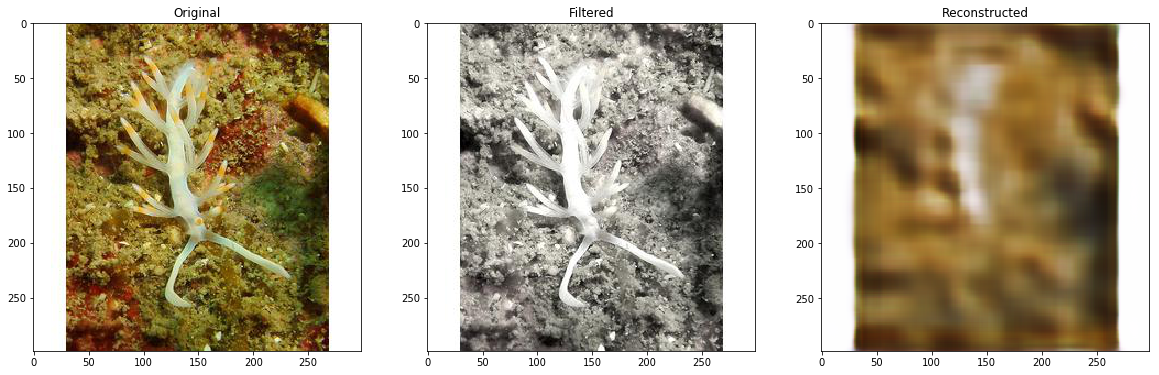

In [37]:
import matplotlib
%matplotlib inline 

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

for k in range(8):
    original = ((127.5*image_out[k])+127.5).astype("uint8")
    estimation = ((127.5*pred[k])+127.5).astype("uint8")
    filtered =  ((127.5*image_in[k])+127.5).astype("uint8")
    # Four axes, returned as a 2-d array
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(original)
    axarr[0].set_title('Original')
    axarr[1].imshow(filtered)
    axarr[1].set_title('Filtered')
    axarr[2].imshow(estimation)
    axarr[2].set_title('Reconstructed')

    f.show()

TODO:

* Test this notebook using a TFRecord file
    * Add Merge Layer using Inception embeddings [ref](https://github.com/fchollet/keras/issues/4505)
* Need of a Validation set
* Padding: It feels like the network devotes some time trying to detect the padding. We might consider not caring at all what the network outputs in the padding regions.
* Adam Optimizer good? Learning Rate?
* Regularization term might be usefull in future.